### Day 12 - conv2d with shared memory and halo

In [ ]:
import time
import pandas as pd
import numpy as np
from math import prod
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

import warn_options

In [ ]:
from lovely_numpy import Lo
from lovely_tensors import monkey_patch

monkey_patch()
import torch
from torch import Tensor
from torch.nn.functional import conv2d

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

device = cuda.Device(0)

print(f"Cuda version: {".".join([str(i) for i in cuda.get_version()])}")
print(f"Device:\t{device.name()}")

Cuda version: 12.8.0
Device:	NVIDIA GeForce RTX 3080 Laptop GPU


In [ ]:
cu_file = "kernels/conv2d/conv2d-z-out-shared-halo.cu"

In [ ]:
#|output: asis
#|echo: false

c_code = Path(cu_file).read_text()
print(f'''

### [{cu_file}](https://github.com/xl0/cuda-100/blob/master/nbs/{cu_file})

::: {{.sourceCode}}
```cpp
{c_code}
```
:::
''')



### [kernels/conv2d/conv2d-z-out-shared-halo.cu](https://github.com/xl0/cuda-100/blob/master/nbs/kernels/conv2d/conv2d-z-out-shared-halo.cu)

::: {.sourceCode}
```cpp
#include <stdint.h>
#include <stdio.h>

#include "conv2d-helpers.h"

/* In this version, we spawn extra threads to copy the tile into cache. */
__global__ void conv2d_pad_z_out_shared_halo(
    float *in,
    float *out,
    float *filter,
    int h,
    int w,
    int in_channels,
    int out_channels,
    int filter_size /* Must be an odd number */,
    float pad
#ifdef SINGLE_BLOCK
    ,
    int *debug_counter /* This allows you to run the kernel one block at a time */
#endif

) {
    int filter_r = (filter_size - 1) / 2;

    int output_suze = TILE_SIZE - filter_size + 1;

    int out_x = blockIdx.x * output_suze + threadIdx.x - filter_r;
    int out_y = blockIdx.y * output_suze + threadIdx.y - filter_r;

    int out_ch = blockIdx.z;

    extern __shared__ float cell[];

    // In and Out data dimensions:
    // 0 -

In [ ]:
from typing import Optional

In [ ]:
def benchmark_conv2d_pad(
    kernel,
    block_size: tuple[int],
    grid_size: tuple[int],
    shared_mem_size: Optional[int],
    input: np.array,
    filter: np.array,
    repeat: int = 5,
    verbose=False
):
    # input, channel-first
    # - Channel
    # - Height
    # - Width
    assert len(input.shape) == 3

    # Filter shape should be
    # - Out channels
    # - In  channels
    # - Height
    # - Width
    assert len(filter.shape) == 4

    in_ch, h, w = input.shape
    out_ch, in_ch2, fh, fw = filter.shape

    assert fh == fw, f"Only square filters supported, got shape={filter.shape}"
    assert in_ch == in_ch2

    out_shape = (out_ch, h, w)
    pad = 0

    if verbose:
        print(f"Input shape: {input.shape}")
        print(f"Filter shape: {filter.shape}")
        print(f"Result shape: {out_shape}")
        print(f"Grid size: {grid_size}")
        print(f"Block size: {block_size}")
        print(f"Shared memory size: {shared_mem_size}")
        print(f"Total threads: {prod((*grid_size, *block_size))}")

    gpu_input = cuda.mem_alloc_like(input)
    gpu_filter = cuda.mem_alloc_like(filter)

    out = np.empty(out_shape, dtype=np.float32)

    cuda.memcpy_htod(gpu_input, input)
    cuda.memcpy_htod(gpu_filter, filter)

    cuda.Context.synchronize()

    timing = 0

    for _ in range(repeat):
        start = cuda.Event()
        end = cuda.Event()

        gpu_out = cuda.mem_alloc_like(out)

        cuda.Context.synchronize()
        start.record()

        shared_kwarg = {}
        if shared_mem_size is not None:
            shared_kwarg = {"shared": shared_mem_size}

        kernel(
            gpu_input,
            gpu_out,
            gpu_filter,
            np.int32(h),
            np.int32(w),
            np.int32(in_ch),
            np.int32(out_ch),
            np.int32(fh),
            np.float32(pad),
            grid=grid_size,
            block=block_size,
            **shared_kwarg
        )
        end.record()
        end.synchronize()

        timing += end.time_since(start)
    timing /= repeat

    cuda.memcpy_dtoh(out, gpu_out)
    cuda.Context.synchronize()
    return out, timing


In [ ]:
def benchmark_conv2d_pad_z_out_shared_halo(kernel, input: np.array, filter: np.array, tile_size: int, **kwargs):
    in_ch, h, w = input.shape
    out_ch, in_ch2, fh, fw = filter.shape

    assert fh == fw

    output_tile_size = tile_size - fw + 1

    block_size = (tile_size, tile_size, 1)
    grid_size = (((w+output_tile_size-1) // output_tile_size), ((h+output_tile_size-1) // output_tile_size), out_ch)
    shared = (output_tile_size+fw) * (output_tile_size+fh) * 4

    return benchmark_conv2d_pad(
        kernel=kernel, input=input, filter=filter, block_size=block_size, grid_size=grid_size, shared_mem_size=shared, **kwargs
    )


In [ ]:
def benchmark_conv2d_pad_naive(kernel, input: np.array, filter: np.array, tile_width, **kwargs):
    in_ch, h, w = input.shape
    out_ch, in_ch2, fh, fw = filter.shape

    block_size = (tile_width, tile_width, 1)
    grid_size = (((w+tile_width-1) // tile_width), ((h+tile_width-1) // tile_width), 1)

    return benchmark_conv2d_pad(kernel=kernel, input=input, filter=filter, block_size=block_size, grid_size=grid_size, **kwargs)


In [ ]:
in_chan_range = [1, 3, 8, 32, 128, 512]
out_chan_range = [1, 4, 8, 32, 128, 512]

filter_size = [1, 3, 5, 9]

img_size_range = [64, 128, 256, 512, 1024]

# Let's sample from the available options.
n_samples = 50

# Generate all possible combinations
combinations = []
for in_ch in in_chan_range:
    for out_ch in out_chan_range:
        for fs in filter_size:
            for img_size in img_size_range:
                n = in_ch * out_ch * img_size * img_size

                # Skip combinatoins that are too large
                if n < 1024 * 1024 * 32 * 32:
                    combinations.append((in_ch, out_ch, fs, img_size))

n_samples = min(n_samples, len(combinations))
sampled_combinations = np.random.choice(len(combinations), size=n_samples, replace=False)
test_cases = [combinations[i] for i in sampled_combinations]

### Using `double` for accumulator

I've noticed that we get a lot less discrepency between torch and my implementation when using a double for accumulator.
Let's benchmark the two.

In [ ]:
tile_size = 16

# test_cases = [(512, 128, 9, 64)]


# + ["-DDEBUG=1"],
mod = SourceModule(
    Path(cu_file).read_text(),
    options=warn_options.warn_options + ["-DACCUM_DTYPE=float", f"-DTILE_SIZE={tile_size}"],
    include_dirs=[str(Path("./kernels/conv2d/").absolute())]
)
mod_double = SourceModule(
    Path(cu_file).read_text(),
    options=warn_options.warn_options + ["-DACCUM_DTYPE=double", f"-DTILE_SIZE={tile_size}"],
    include_dirs=[str(Path("./kernels/conv2d/").absolute())]
)

benchmarks = {
    "conv2d_pad_z_out_shared_halo_float": (
        benchmark_conv2d_pad_z_out_shared_halo,
        mod.get_function("conv2d_pad_z_out_shared_halo")
        ),
    "conv2d_pad_z_out_shared_halo_double": (
        benchmark_conv2d_pad_z_out_shared_halo,
        mod_double.get_function("conv2d_pad_z_out_shared_halo")
        )
}

def run_benchmarks(benchmarks, test_cases):
    data = []

    for tc in tqdm(test_cases):
        ch_in, ch_out, fs, pixels = tc

        array_in = np.random.randn(ch_in, pixels, pixels).astype(np.float32)
        filter = np.random.randn(ch_out, ch_in, fs, fs).astype(np.float32)


        torch_out = conv2d(Tensor(array_in), Tensor(filter), padding="same")

        timings = {}

        for benchmark_name, (benchmark_func, kernel) in benchmarks.items():
            res, timing = benchmark_func(kernel, input=array_in, filter=filter, tile_size=tile_size, repeat=5)

            similarity = float(np.isclose(res, torch_out, atol=1e-04, rtol=1e-4).mean())
            if similarity < 0.9:
                print(f"## Mismatch for '{benchmark_name}")
                print(f"In: {array_in.shape}")
                print(f"Out: {(ch_out, pixels, pixels)}")
                print(f"Filter: {filter.shape}")
                print(f"Similarity: {similarity}")

                # display(Lo(np.isclose(res, torch_out,  atol=1e-04, rtol=1e-4)).chans(cl=False, scale=2))
                # raise Exception

            timings[benchmark_name] = timing
            # time.sleep(10)

        cuda.Context.synchronize()

        data.append({
            'in_ch': ch_in,
            'out_ch': ch_out,
            'filter_size': fs,
            'img_size': pixels,
            # 'kernel': kernel_name,
        } | timings)

    return pd.DataFrame(data)


In [ ]:
results = run_benchmarks(benchmarks, test_cases)

  0%|          | 0/50 [00:00<?, ?it/s]

### Results

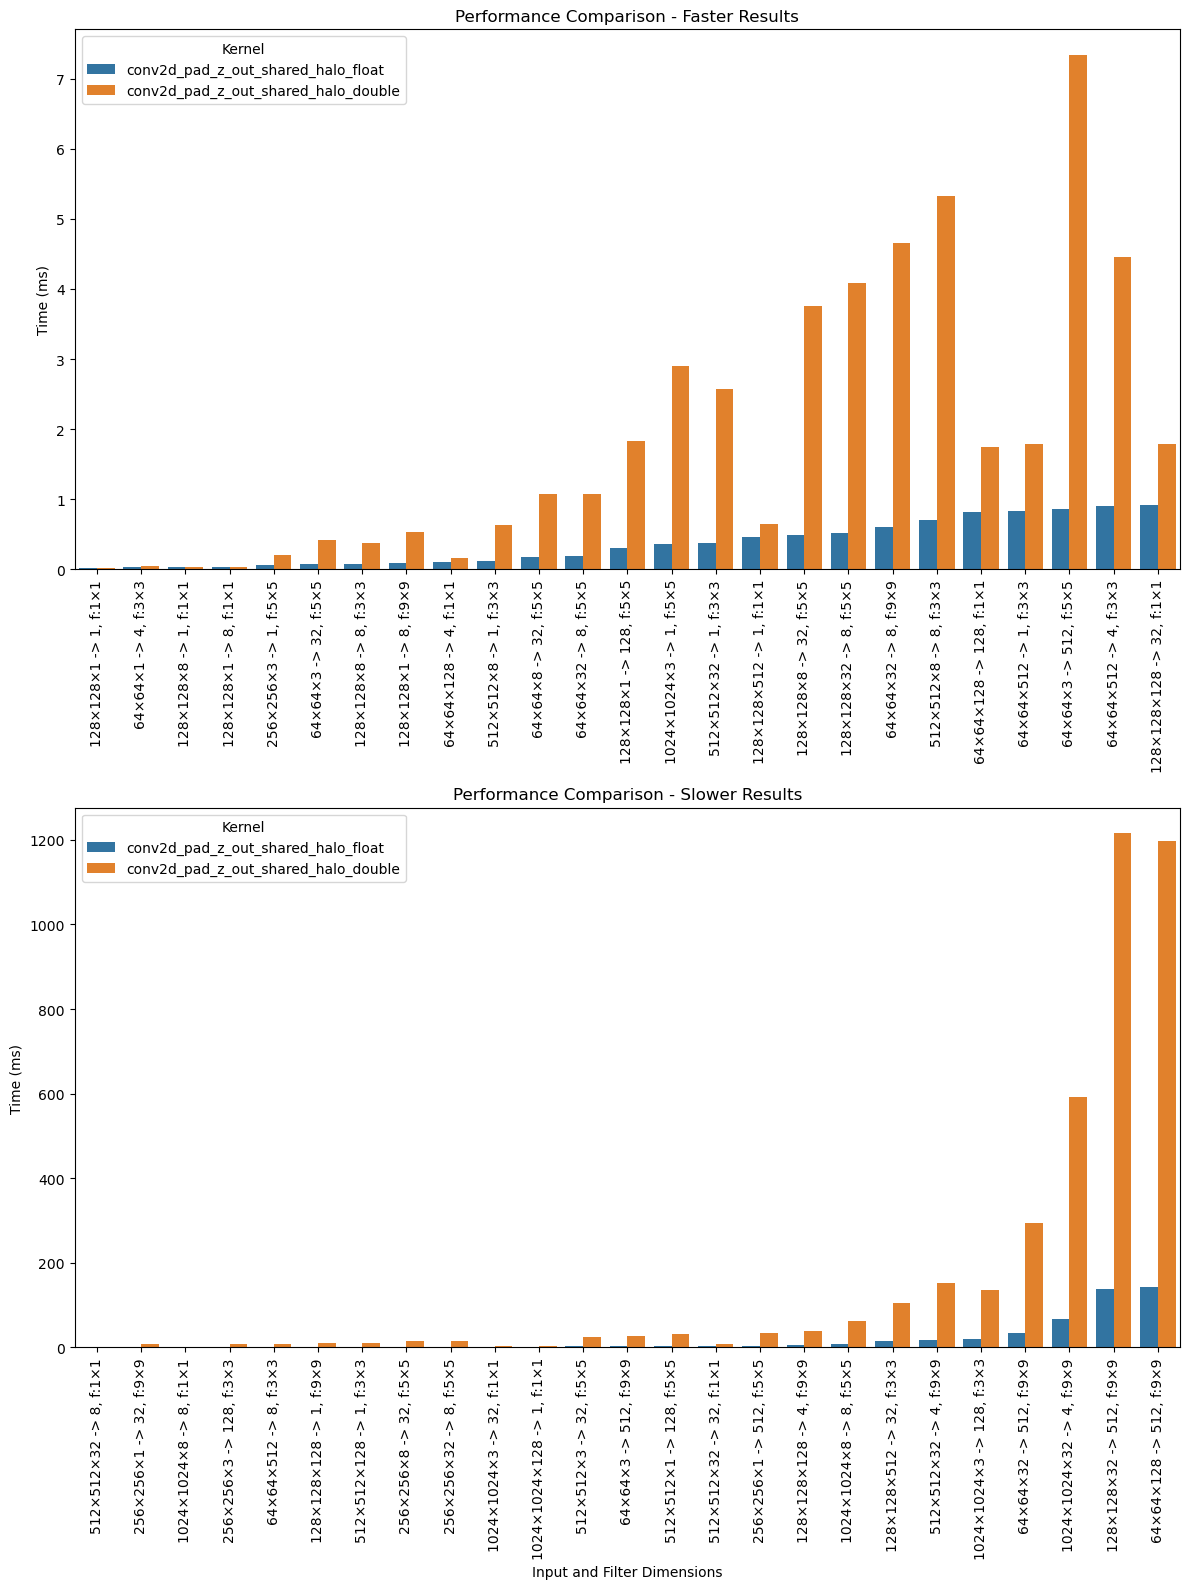

In [ ]:
def plot_results(results, sort_column: str, timing_columns: list[str]):

    # Sort by conv2d_pad timing
    results_sorted = results.sort_values(by=sort_column)

    # Create a plot comparing the two kernels
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Create labels for x-axis that include dimensions
    results_sorted['dimensions'] = results_sorted.apply(
        lambda row:
        f"{int(row['img_size'])}×{int(row['img_size'])}×{int(row['in_ch'])} -> " +
        f"{int(row['out_ch'])}, f:{int(row['filter_size'])}×{int(row['filter_size'])}",
        axis=1
    )

    # Melt the dataframe to get it in the right format for seaborn
    melted_results = pd.melt(
        results_sorted,
        id_vars=['in_ch', 'out_ch', 'filter_size', 'img_size', 'dimensions'],
        value_vars=timing_columns,
        var_name='kernel',
        value_name='time'
    )

    # Split the data into two halves based on timing
    midpoint = len(results_sorted) // 2
    faster_results = melted_results[melted_results['dimensions'].isin(results_sorted['dimensions'][:midpoint])]
    slower_results = melted_results[melted_results['dimensions'].isin(results_sorted['dimensions'][midpoint:])]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

    # Plot faster results in the first subplot
    sns.barplot(x='dimensions', y='time', hue='kernel', data=faster_results, ax=ax1)
    ax1.set_xlabel('')
    ax1.set_ylabel('Time (ms)')
    ax1.set_title('Performance Comparison - Faster Results')
    ax1.tick_params(axis='x', rotation=90)
    ax1.legend(title='Kernel')

    # Plot slower results in the second subplot
    sns.barplot(x='dimensions', y='time', hue='kernel', data=slower_results, ax=ax2)
    ax2.set_xlabel('Input and Filter Dimensions')
    ax2.set_ylabel('Time (ms)')
    ax2.set_title('Performance Comparison - Slower Results')
    ax2.tick_params(axis='x', rotation=90)
    ax2.legend(title='Kernel')

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_results(results,
             "conv2d_pad_z_out_shared_halo_float",
             ["conv2d_pad_z_out_shared_halo_float", "conv2d_pad_z_out_shared_halo_double"])

# Also display the sorted results table
# results_sorted

Ok, double is slow AF. I guess I'll stick to the float accumulator.
We will compare all the kernels to date tomorrow.